In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from datasetsforecast.m3 import M3

from ruptures.detection import Pelt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression as SkLearnLinearRegression
from statsmodels.tsa.stattools import acf

current_working_directory = os.getcwd()
project_root = os.path.abspath(os.path.join(current_working_directory, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added to sys.path: {project_root}")
else:
    print(f"{project_root} is already in sys.path.")

from testing.test_easyts import test_deeptsanalysis_metrics

Added to sys.path: c:\Users\Utilizador\Desktop\Faculdade\Projeto Investigação - Séries Temporais\EasyTest


In [2]:
print("Loading M3 Monthly data for plotting...")
Y_df = None
DATA_LOADED_FOR_PLOTTING = False

data_dir = os.path.join(project_root, 'data', 'm3_download')
os.makedirs(data_dir, exist_ok=True)

loaded_data = M3.load(directory=data_dir, group='Monthly')

if isinstance(loaded_data, (list, tuple)) and len(loaded_data) > 0:
    Y_df = loaded_data[0]
elif isinstance(loaded_data, pd.DataFrame):
    Y_df = loaded_data

if Y_df is not None and not Y_df.empty:
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    print(f"M3 Monthly data loaded successfully for plotting. Shape: {Y_df.shape}")
    DATA_LOADED_FOR_PLOTTING = True
else:
    print("Failed to load M3 Monthly data for plotting or data is empty.")


Loading M3 Monthly data for plotting...
M3 Monthly data loaded successfully for plotting. Shape: (167562, 3)


In [4]:
def display_parameter_table(parameter_details_list):
    if not parameter_details_list:
        pass

    else:
        df_params = pd.DataFrame(parameter_details_list, columns=["Parameter", "Type", "Default", "Description"])

        styled_df = df_params.style \
            .set_properties(**{  
                'text-align': 'left',
                'vertical-align': 'top', 
                'border': '1px solid #ddd', 
                'padding': '5px'
            }) \
            .set_properties(subset=['Description'], **{ 
                'min-width': '300px',     
                'max-width': '450px',     
                'white-space': 'normal',  
                'word-wrap': 'break-word' 
            }) \
            .set_properties(subset=['Parameter'], **{
                'min-width': '100px',
                'font-weight': 'bold'
                }) \
            .set_properties(subset=['Type'], **{'min-width': '60px'}) \
            .set_properties(subset=['Default'], **{
                'min-width': '120px',
                'white-space': 'normal', 
                'word-wrap': 'break-word'
                }) \
            .set_table_styles([
                {'selector': 'th',
                    'props': [('background-color', '#f2f2f2'),
                            ('color', 'black'),
                            ('font-weight', 'bold'),
                            ('text-align', 'left'),
                            ('border', '1px solid #ddd'),
                            ('padding', '5px')]}
            ], overwrite=False) \
            .hide(axis='index') 

        display(HTML(styled_df.to_html(escape=False)))

In [5]:
print("\nProcessing calculated extreme feature values...")
extreme_datasets_info = {} 

calculated_extremes = test_deeptsanalysis_metrics()
if calculated_extremes is not None and isinstance(calculated_extremes, dict) and calculated_extremes:
    feature_keys_using_new_names = [
        "Trend Changes",
        "Trend Strength",                      
        "Linear Regression Slope",   
        "Linear Regression R2",     
        "Series Forecastability",                       
        "Series Fluctuation",
        "Autocorrelation Relevance",
        "Seasonal Strength",
        "Window Fluctuation",
        "Short-Term Variation",
        "Differenced Series",
        "Series Complexity",
        "Records Concentration",
        "Series Centroid"
    ]

    print(f"Expecting features: {feature_keys_using_new_names}")
    print(f"Available features in calculated_extremes: {list(calculated_extremes.keys())}")


    for feature_key in feature_keys_using_new_names:
        if feature_key not in calculated_extremes:
            print(f"Warning: Feature key '{feature_key}' not found in calculated_extremes dictionary. Skipping.")
            continue

        extreme_pair = calculated_extremes[feature_key]
        if not isinstance(extreme_pair, dict) or 'lowest' not in extreme_pair or 'highest' not in extreme_pair:
            print(f"Warning: Data for feature key '{feature_key}' in calculated_extremes is not in the expected format {{'lowest': (id, val), 'highest': (id, val)}}. Skipping.")
            continue

        low_info = extreme_pair.get('lowest', (None, np.nan))
        high_info = extreme_pair.get('highest', (None, np.nan))

        if not (isinstance(low_info, (tuple, list)) and len(low_info) == 2):
            print(f"Warning: 'lowest' data for '{feature_key}' is malformed: {low_info}. Setting to N/A.")
            low_id, low_val = "N/A", np.nan
        else:
            low_id, low_val = low_info

        if not (isinstance(high_info, (tuple, list)) and len(high_info) == 2):
            print(f"Warning: 'highest' data for '{feature_key}' is malformed: {high_info}. Setting to N/A.")
            high_id, high_val = "N/A", np.nan
        else:
            high_id, high_val = high_info

        temp_extreme_info_entry = {
            "low_id": str(low_id) if pd.notna(low_id) and low_id is not None else "N/A",
            "low_val": low_val,
            "high_id": str(high_id) if pd.notna(high_id) and high_id is not None else "N/A",
            "high_val": high_val, 
            "source_metric_method": "Refer to Metrics class" 
        }

        if feature_key in ["Trend Changes", "Trend Strength", "Median Crosses", "Linear Regression Slope", "Linear Regression R2"]:
            temp_extreme_info_entry["conceptual_group"] = "Trend/Regression Analysis"
        elif feature_key in ["Forecastability", "Entropy Pairs", "Series Fluctuation"]:
            temp_extreme_info_entry["conceptual_group"] = "Complexity/Noise/Forecastability Analysis"

        extreme_datasets_info[feature_key] = temp_extreme_info_entry

    if extreme_datasets_info:
        print("\n--- Summary of Extreme Values (New Names) ---")
        for feature, info in extreme_datasets_info.items():
            low_val_str = f"{info['low_val']:.4f}" if pd.notna(info['low_val']) else "N/A"
            high_val_str = f"{info['high_val']:.4f}" if pd.notna(info['high_val']) else "N/A"
            print(f"  Feature: {feature} (Group: {info.get('conceptual_group', 'N/A')})")
            print(f"    Lowest:  ID = {info['low_id']}, Value = {low_val_str}")
            print(f"    Highest: ID = {info['high_id']}, Value = {high_val_str}")
    else:
        print("\nNo extreme dataset information was mapped. 'calculated_extremes' might be empty, all keys might have been missing, or data was malformed.")

elif calculated_extremes is None:
    print("\nSkipping processing: 'calculated_extremes' is None (was not populated).")
else: # calculated_extremes is not None, but might be empty dict or wrong type
    print(f"\nSkipping processing: 'calculated_extremes' is not a non-empty dictionary (type: {type(calculated_extremes)}).")


Processing calculated extreme feature values...

Loading M3 Monthly data (will download to 'c:\Users\Utilizador\Desktop\Faculdade\Projeto Investigação - Séries Temporais\EasyTest\data\m3_download' if needed)...
Data loaded successfully.

Analyzing 1428 monthly time series using the Metrics class...
Processed 1/1428 series... (Checked 1, Skipped 0)
Processed 100/1428 series... (Checked 100, Skipped 0)
Processed 200/1428 series... (Checked 200, Skipped 0)
Processed 300/1428 series... (Checked 300, Skipped 0)
Processed 400/1428 series... (Checked 400, Skipped 0)
Processed 500/1428 series... (Checked 500, Skipped 0)
Processed 600/1428 series... (Checked 600, Skipped 0)
Processed 700/1428 series... (Checked 700, Skipped 0)
Processed 800/1428 series... (Checked 800, Skipped 0)
Processed 900/1428 series... (Checked 900, Skipped 0)
Processed 1000/1428 series... (Checked 1000, Skipped 0)
Processed 1100/1428 series... (Checked 1100, Skipped 0)
Processed 1200/1428 series... (Checked 1200, Skippe

## **trend_strength**

Computes the strength of a trend within the time-series.  
**Low value:** A value close to zero means there are few/none indicators of a trend in the time series.  
**High value:** A value close to one means there are strong signs of the series containing a trend.

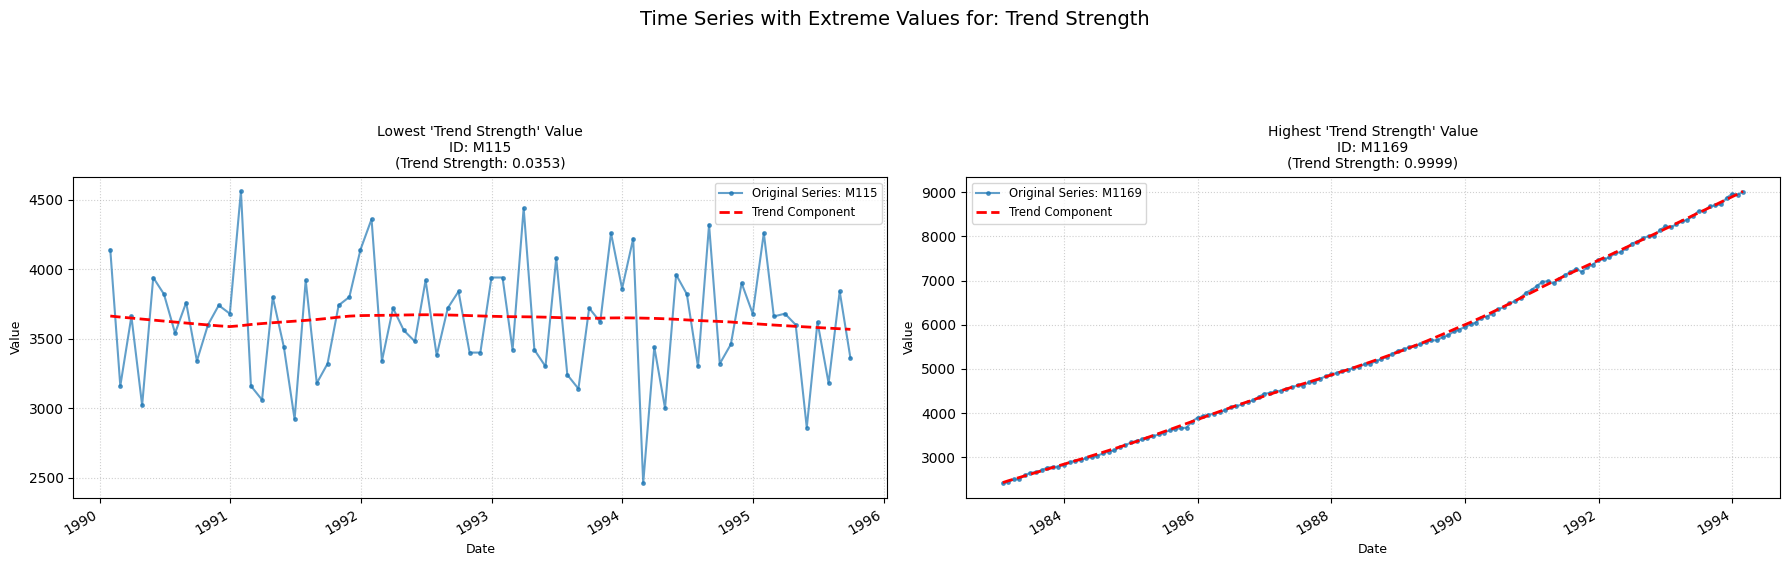

In [5]:
# --- Feature to Plot ---
feature_to_plot = "Trend Strength"

# --- Check if data for the feature is available ---
if feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_id"],
        f"Highest '{feature_to_plot}' Value": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_val"],
        f"Highest '{feature_to_plot}' Value": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']

            seasonal_period_for_stl = 12 
            seasonal_smoother_len = 7  
            
            if len(series_np) <= 2 * seasonal_smoother_len :
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short for STL: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short for STL', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- STL Decomposition for "Trend Strength" ---
            recalculated_feature_value = np.nan
            trend_component_to_plot = None
            
            try:
                stl = STL(series_np, period=seasonal_period_for_stl, seasonal=seasonal_smoother_len, robust=True)
                res = stl.fit()
                
                trend_component_to_plot = res.trend
                seasonal_component = res.seasonal 
                remainder_component = res.resid  

                var_R = np.var(remainder_component, ddof=1)
                var_TR = np.var(series_np - seasonal_component, ddof=1) 
                
                if var_TR <= 1e-10:
                    recalculated_feature_value = 0.0
                else:
                    recalculated_feature_value = max(0.0, 1.0 - (var_R / var_TR))
            except Exception as e:
                recalculated_feature_value = "STL Error"


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Original Series: {target_id}", alpha=0.7)

            if trend_component_to_plot is not None:
                ax.plot(series_dates, trend_component_to_plot, linestyle='--', color='red', lw=2, label="Trend Component")

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]

            if pd.notna(stored_feature_val):
                title_parts.append(f"(Trend Strength: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})")
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]):
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)


##### **Parameters Table**

In [6]:
parameter_details_list = [
    {
        "Parameter": "period", "Type": "int", 
        "Description": "Frequency of the time series (e.g. 12 for monthly)", 
        "Default": "1"
    },
    {
        "Parameter": "seasonal", "Type": "int",
        "Description": "Length of the seasonal smoother (must be odd).",
        "Default": "7"
    },
    {
        "Parameter": "robust", "Type": "bool",
        "Description": "Flag for robust fitting.",
        "Default": "False"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
period,int,1,Frequency of the time series (e.g. 12 for monthly)
seasonal,int,7,Length of the seasonal smoother (must be odd).
robust,bool,False,Flag for robust fitting.


##### **Calculation**

1.  **STL Decomposition:** The time series (Yt) is decomposed into trend (Tt), seasonal (St), and remainder (Rt) components, such that Yt=Tt+St+Rt (for additive decomposition). This is done iteratively:

    - An initial trend is estimated (using a moving average).

    - The series is detrended (Yt−Tt).

    - The seasonal component is estimated by averaging the detrended series over each seasonal period and then smoothing these seasonal sub-series (using Loess).

    - The seasonal component is removed from the original series to get a seasonally adjusted series (Yt−St).

    - A new trend component Tt is estimated by smoothing the seasonally adjusted series (using Loess).

    - These steps are repeated a few times for robustness.

2.	**Deseasonalized Series:** The deseasonalized series is calculated as Dt=Yt−St=Tt+Rt.

3.	**Variances:**

    - The variance of the remainder component is calculated: Var(Rt).

    - The variance of the deseasonalized series is calculated: Var(Dt).

4.	**Strength Calculation:** Trend strength is computed as: strength=max(0,1−Var(Dt)Var(Rt)). The result is capped between 0 and 1 and returned.


##### **Practical Usefulness Examples**

**Retail Sales**: A business analyst can use trend strength to assess if an observed increase in monthly sales is a statistically significant upward movement or just part of normal random fluctuations. A strong trend might justify increased inventory orders, while a weak trend might suggest caution.

**Stock Market Analysis**: An investor could use trend strength to determine if a stock price is in a strong, reliable uptrend or downtrend, influencing buy/sell decisions, rather than reacting to short-term volatility.


## **trend_changes**

Detects the number of points where the trend changes.  
**Low value:** The trend has few/none shifting points, and is constant through time.  
**High value:** The trend is constantly shifting, provoking many structural changes.

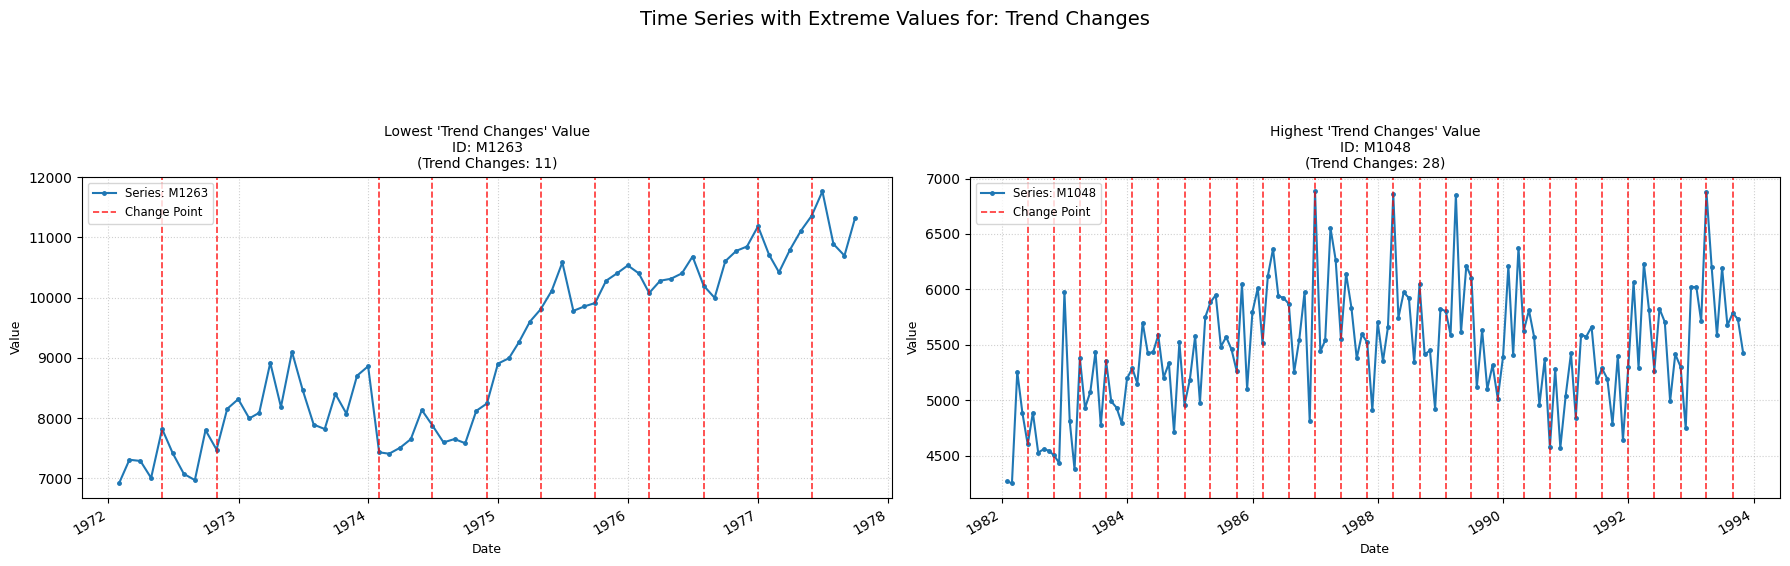

In [7]:
# --- Feature to Plot ---
feature_to_plot = "Trend Changes"

# --- Check if data for the feature is available ---
if feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        "Lowest 'Trend Changes' Value": details["low_id"],
        "Highest 'Trend Changes' Value": details["high_id"]
    }

    # Stored feature values (count of trend changes)
    stored_values_map = {
        "Lowest 'Trend Changes' Value": details["low_val"],
        "Highest 'Trend Changes' Value": details["high_val"]
    }

    # Filter out N/A IDs for plotting
    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": target_id, "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten()
        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']

            if len(series_np) < 2: # Pelt needs at least 2 points for default min_size
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            recalculated_feature_value = 0 
            bkps_to_plot = []

            pelt_detector = Pelt(model="l2", min_size=2, jump=5)
            pen_value = np.log(len(series_np)) if len(series_np) > 1 else 0
            pelt_detector.fit(series_np)
            bkps_indices = pelt_detector.predict(pen=pen_value)
            
            if bkps_indices and len(bkps_indices) > 1:
                bkps_to_plot = [b for b in bkps_indices[:-1] if 0 < b < len(series_np)]
                recalculated_feature_value = len(bkps_to_plot)
            
            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}")

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val):
                title_parts.append(f"(Trend Changes: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.0f}'})")
            
            ax.set_title("\n".join(title_parts), fontsize=10)

            if bkps_to_plot:
                first_bkp_line = True
                for b_idx in bkps_to_plot:
                    if 0 < b_idx <= len(series_dates):
                        plot_date_idx = b_idx -1
                        if plot_date_idx < 0: continue

                        b_date = series_dates.iloc[plot_date_idx]
                        line_label = 'Change Point' if first_bkp_line else None
                        ax.axvline(b_date, color='red', linestyle='--', lw=1.2, alpha=0.8, label=line_label)
                        first_bkp_line = False
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        

        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **Parameters Table**

In [8]:
parameter_details_list = [
    {
        "Parameter": "model", "Type": "str", 
        "Description": "Cost function model (e.g., 'l1', 'l2', 'rbf')", 
        "Default": "'l2'"
    },
    {
        "Parameter": "min_size", "Type": "int",
        "Description": "Minimum number of samples in a segment.",
        "Default": "2"
    },
    {
        "Parameter": "jump", "Type": "int",
        "Description": "Subsample window for considering change points.",
        "Default": "5"
    },
    {
        "Parameter": "params", "Type": "dict or None",
        "Description": "Additional parameters dictionary for the cost 'model'.",
        "Default": "None"
    },
    {
        "Parameter": "custom_cost", "Type": "BaseCost or None",
        "Description": "Custom cost function (overrides 'model').",
        "Default": "None"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
model,str,'l2',"Cost function model (e.g., 'l1', 'l2', 'rbf')"
min_size,int,2,Minimum number of samples in a segment.
jump,int,5,Subsample window for considering change points.
params,dict or None,None,Additional parameters dictionary for the cost 'model'.
custom_cost,BaseCost or None,None,Custom cost function (overrides 'model').


##### **Calculation**

1.  **Pelt Algorithm (Pruned Exact Linear Time):** The minimum cost for segmenting the series up to a point t is calculated. This is done by considering all possible previous points s. For each s, the known minimum cost to segment up to s is used, and the cost of the current segment (from s to t-1) is added alongside a penalty term. The minimum cost is then the smallest value found among all these possible s points. This cost is computed iteratively for every point in the series.

2. **Breakpoints Counting:** The value returned is the number of detected changepoints (breakpoints) found by backtracking through these optimal choices.



##### **Practical Usefulness Examples**

**Economic Analysis:** Identifying when an economic indicator like GDP growth rate or unemployment changes its trend can signal shifts in the economic cycle, informing policy decisions.

**Marketing Campaign Analysis:** Detecting trend changes in website traffic or conversion rates after launching a marketing campaign can help assess its impact and identify when its effectiveness starts or wanes.



## **linear_regression_slope**

Measures the overall linear trend slope.  
**Low value:** A negative value means there is a downward trend.  
**High value:** A positive value means an upward trend.

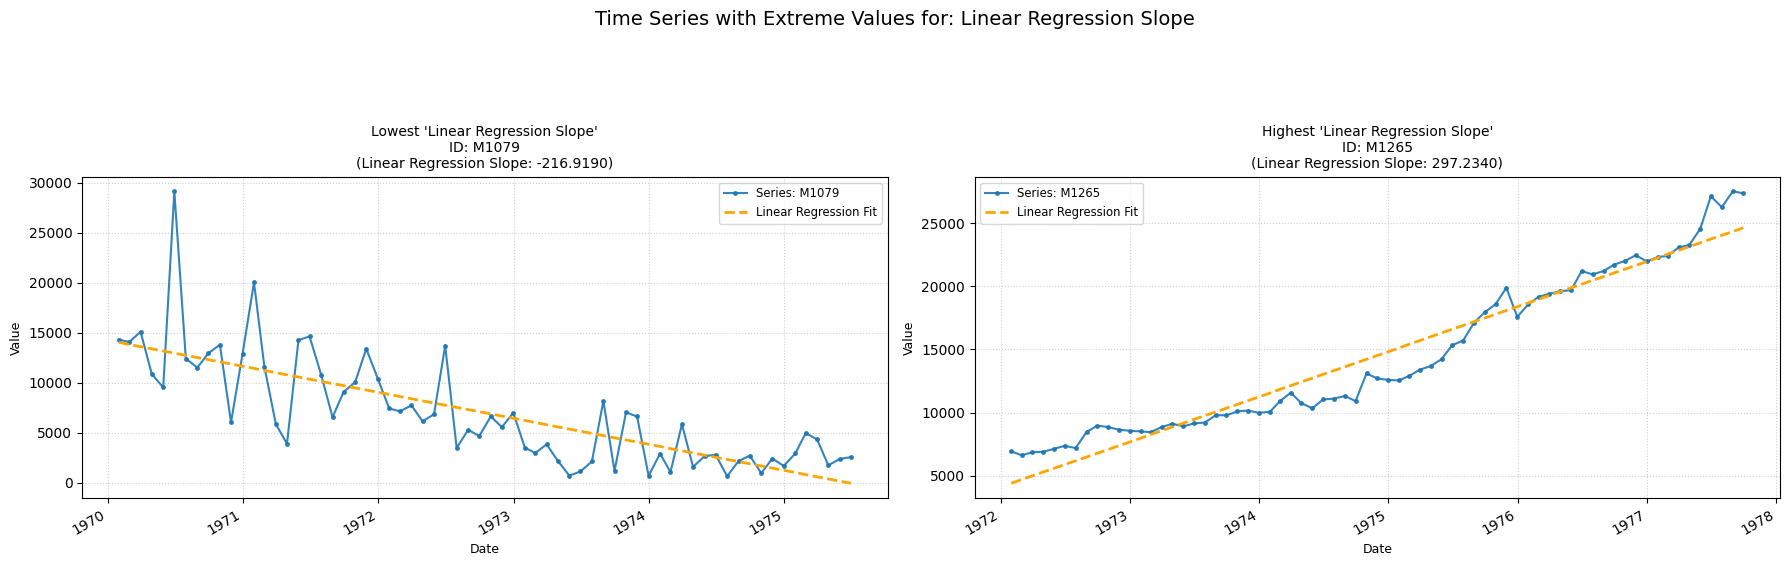

In [9]:
# --- Feature to Plot ---
feature_to_plot = "Linear Regression Slope"

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            # Linear regression requires at least 2 points.
            if len(series_np) < 2:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Calculation for "Linear Regression Slope" ---

            regression_line_to_plot = None 
            

            time_steps = np.arange(len(series_np)).reshape(-1, 1)
            try:
                model = SkLearnLinearRegression()
                model.fit(time_steps, series_np)
                regression_line_to_plot = model.predict(time_steps)
            except Exception: 
                ax.text(0.5, 0.5, 'LR Calc Error', ha='center', va='center')


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)

            if regression_line_to_plot is not None:
                ax.plot(series_dates, regression_line_to_plot, linestyle='--', color='orange', lw=2, label="Linear Regression Fit")
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.  **Linear Regression Fitting:** First, the linear regression model yi=β0+β1xi is fitted, yielding predicted values yi.

2.  **Ordinary Least Squares (OLS):** Then, the returned value (slope β1) is estimated by minimizing the sum of squared residuals.

##### **Practical Usefulness Examples**

**Resource Depletion:** While analyzing the production data of an oil well, the linear regression slope can estimate the average rate of decline in production per month, helping to forecast its remaining lifespan.

**Agricultural Yields:** Farmers can use the slope from regressing crop yield against year to understand the average annual increase or decrease in productivity due to factors like soil changes or farming practices.


## **linear_regression_r2**

Measures how well a linear trend fits the time-series.  
**Low value:** A value close to zero means a linear model explains little variance.  
**High value:** A value close to one means a linear model explains much of the variance.

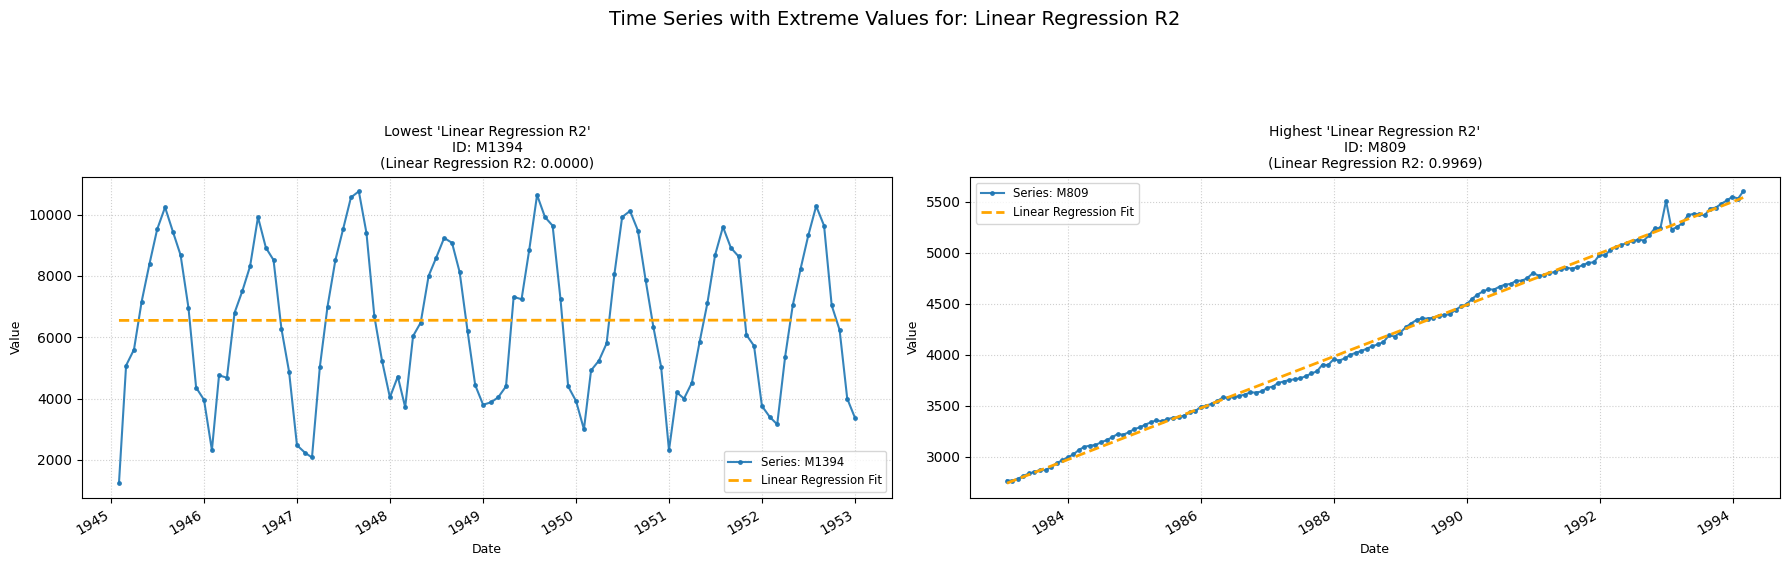

In [10]:
# --- Feature to Plot ---
feature_to_plot = "Linear Regression R2"

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: # Linear regression requires at least 2 points.
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Calculation for Linear Regression ---
            regression_line_to_plot = None
            
            time_steps = np.arange(len(series_np)).reshape(-1, 1)
            try:
                model = SkLearnLinearRegression()
                model.fit(time_steps, series_np)
                regression_line_to_plot = model.predict(time_steps)
            except NameError: 
                print("ERROR: SkLearnLinearRegression not defined. Please import it.")
                ax.text(0.5, 0.5, 'LR Calc Error\n(Import Missing)', ha='center', va='center')
            except Exception: 
                ax.text(0.5, 0.5, 'LR Calc Error', ha='center', va='center')


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)

            if regression_line_to_plot is not None:
                ax.plot(series_dates, regression_line_to_plot, linestyle='--', color='orange', lw=2, label="Linear Regression Fit")
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.	**Linear Regression Fitting:** First, the linear regression model yi=β0+β1xi is fitted, yielding predicted values y^i.

2.	**Total Sum of Squares (SST):** The total variance in the observed data is then computed as SST.

3.	**Sum of Squared Residual (SSR):** The variance not explained by the model is computed as SSR.

4.	**R-squared Calculation:** The R² value, calculated as R²=1−SST/SSR, is returned.


##### **Practical Usefulness Examples**

**Software Performance:** When analyzing software response time over increasing user load, R² indicates how much of the performance degradation is linearly related to the load. A low R² might suggest other non-linear factors are at play.

**Educational Assessment:** If tracking student test scores over a semester, R² for a linear fit can show how much of the score improvement is explained by a steady learning trend versus other influences.

## **forecastability**

Measures the forecastibility of a time-series.  
**Low value:** Means there are strong signs of a trend across the time-series.  
**High value:** Means the time-series is probably white-noise.

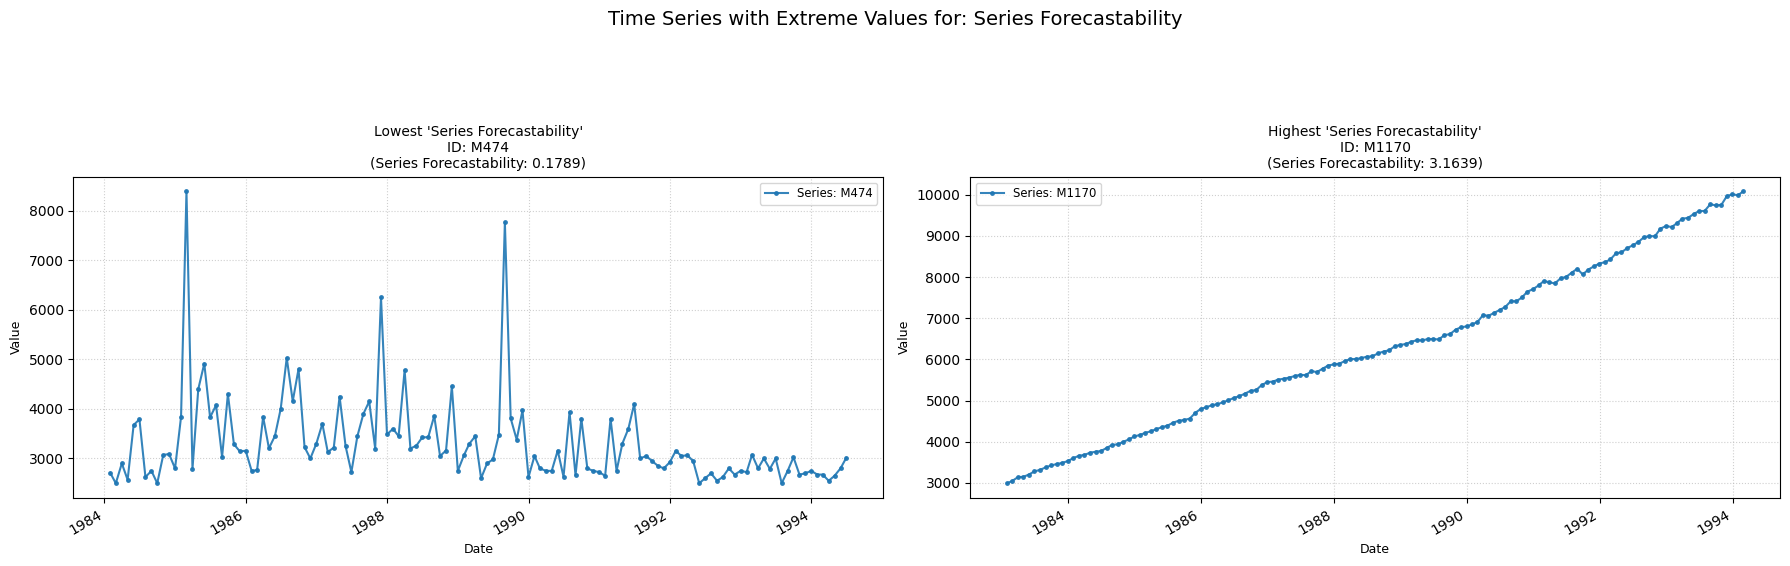

In [11]:
# --- Feature to Plot ---
feature_to_plot = "Series Forecastability" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **Parameters Table**

In [12]:
parameter_details_list = [
    {
        "Parameter": "sf", "Type": "float", 
        "Description": "Sampling frequency.", 
        "Default": "Mandatory"
    },
    {
        "Parameter": "method", "Type": "str",
        "Description": "PSD calculation method ('welch' or 'fft').",
        "Default": "'welch'"
    },
    {
        "Parameter": "nperseg", "Type": "int or None",
        "Description": "Segment length for welch method. If None, default based on data length",
        "Default": "None"
    },
    {
        "Parameter": "normalize", "Type": "bool",
        "Description": "Normalize output to [0, 1]",
        "Default": "False"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
sf,float,Mandatory,Sampling frequency.
method,str,'welch',PSD calculation method ('welch' or 'fft').
nperseg,int or None,None,"Segment length for welch method. If None, default based on data length"
normalize,bool,False,"Normalize output to [0, 1]"


##### **Calculation**

1.	**Power Spectral Density (PSD):** The PSD of the time series is computed. This is done using the user chosen model. The Welch's method (the default model) uses these formula:
o	The series is divided into (potentially overlapping) segments.
o	Each segment is windowed (with a Hann window).
o	The Fast Fourier Transform (FFT) is computed for each windowed segment.
o	The squared magnitude of the FFT gives the periodogram for that segment.
o	The PSD is calculated as the average of these periodograms.

2.	**Normalization:** The PSD is normalized so that it sums to 1, effectively treating it as a probability distribution of power across frequencies.

3.	**Shannon Entropy:** Then the Shannon entropy of this normalized PSD is calculated.

4.	**Forecastability Value:** The computed entropy value is inverted (1/H) and returned.


##### **Practical Usefulness Examples**

**Inventory Management:** For a product with high sales forecastability, a business can maintain lower safety stock. For a product with low forecastability (highly random sales), higher safety stock might be needed to avoid stockouts.

**Call Center Staffing:** If call arrival rates have high forecastability, staffing levels can be optimized more precisely. Low forecastability might require more flexible staffing or overstaffing to handle unpredictable peaks.

## **fluctuation**

Measures the proportion of large changes in the time-series.  
**Low value:** Means few/none large fluctuations.  
**High value:** Means many large fluctuations.

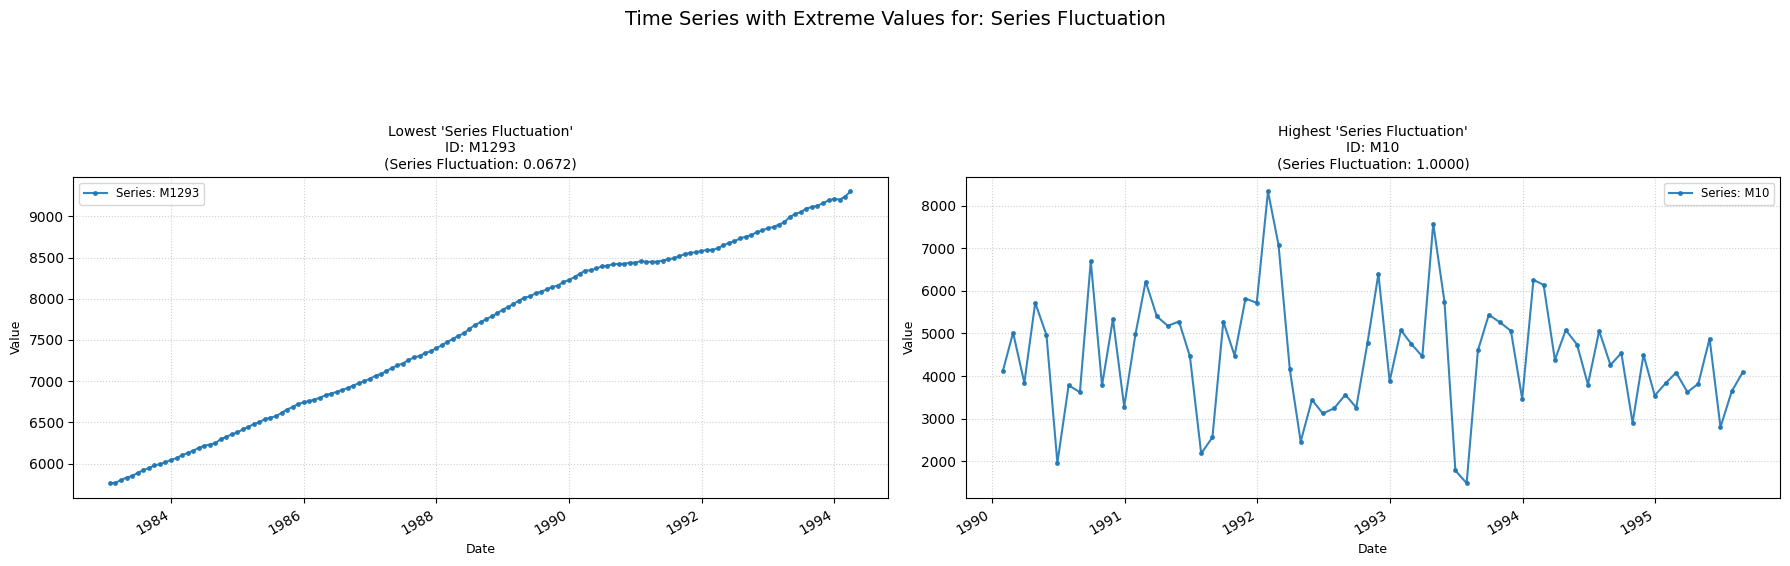

In [13]:
# --- Feature to Plot ---
feature_to_plot = "Series Fluctuation" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.	**Z-Normalization:** First, the time series Yt is z-normalized.

2.	**Successive Differences:** Then the absolute differences between consecutive values of the z-normalized series are calculated.

3.	**Thresholding and Counting:** The counting of the number of absolute differences that are greater than a defined threshold (0.04) is computed.

4.	**Proportion:** The final value, which is returned, is the proportion of such differences.


##### **Practical Usefulness Examples**

**Financial Market Volatility:** In analyzing stock price differences, a high value might indicate a "jumpy" market with frequent large price changes over short intervals, signaling higher risk or specific trading conditions.

**Wearable Health Monitoring:** For activity data from a wearable, a higher value could distinguish between smooth, consistent activity and erratic, stop-and-go movements.


## **ac_relevance**

Measures the first time lag at which the autocorrelation function drops below 1/e.

**Low value:** Means the series has a more unpredicatble behaviour.  
**High value:** Means the series has a more predictable behaviour.

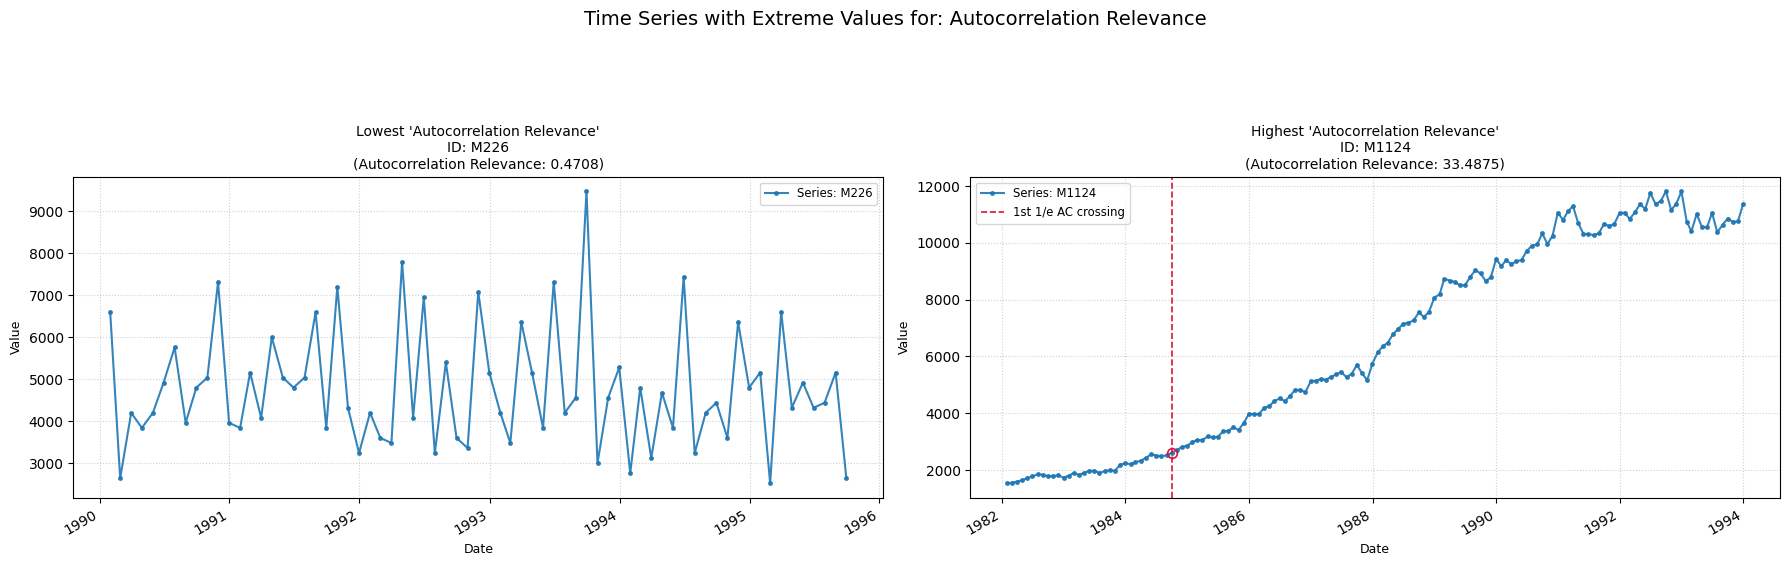

In [14]:
# --- Feature to Plot ---
feature_to_plot = "Autocorrelation Relevance" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            lag_value = stored_feature_val
            if pd.notna(lag_value) and isinstance(lag_value, (int, float, np.number)) and lag_value >= 1:
                lag_index_to_mark = int(round(lag_value)) - 1
                if 0 <= lag_index_to_mark < len(series_dates):
                    crossing_date = series_dates.iloc[lag_index_to_mark]
                    crossing_value_on_series = series_np[lag_index_to_mark]
                    ax.axvline(x=crossing_date, color='crimson', linestyle='--', linewidth=1.2, label=f'1st 1/e AC crossing')
                    ax.plot(crossing_date, crossing_value_on_series, marker='o', color='crimson', markersize=7, fillstyle='none', markeredgewidth=1.2)

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.	**Autocovariance Function (ACVF):** The autocovariance function of the time series Yt is computed for various lags k.

2.	**First 1/e-Crossing:** The feature value is computed and returned as the smallest positive for which ACVF(k) crosses the defined 1/e threshold. 


##### **Practical Usefulness Examples**

**Speech Processing:** In analyzing a speech signal, the first zero-crossing of the autocovariance can be related to the fundamental frequency (pitch) of voiced segments, helping in speech recognition or speaker identification.

**Climate Science:** For temperature data, this feature might indicate the dominant short-term cyclical component (related to diurnal cycles if data is high frequency, for example).


## **seasonal_strength**

Computes the strength of seasonality within the time-series.

**Low value:** A value close to zero means there are few/none indicators of seasonality in the time series.  
**High value:** A value close to one means there are strong signs of seasonality in the time-series.

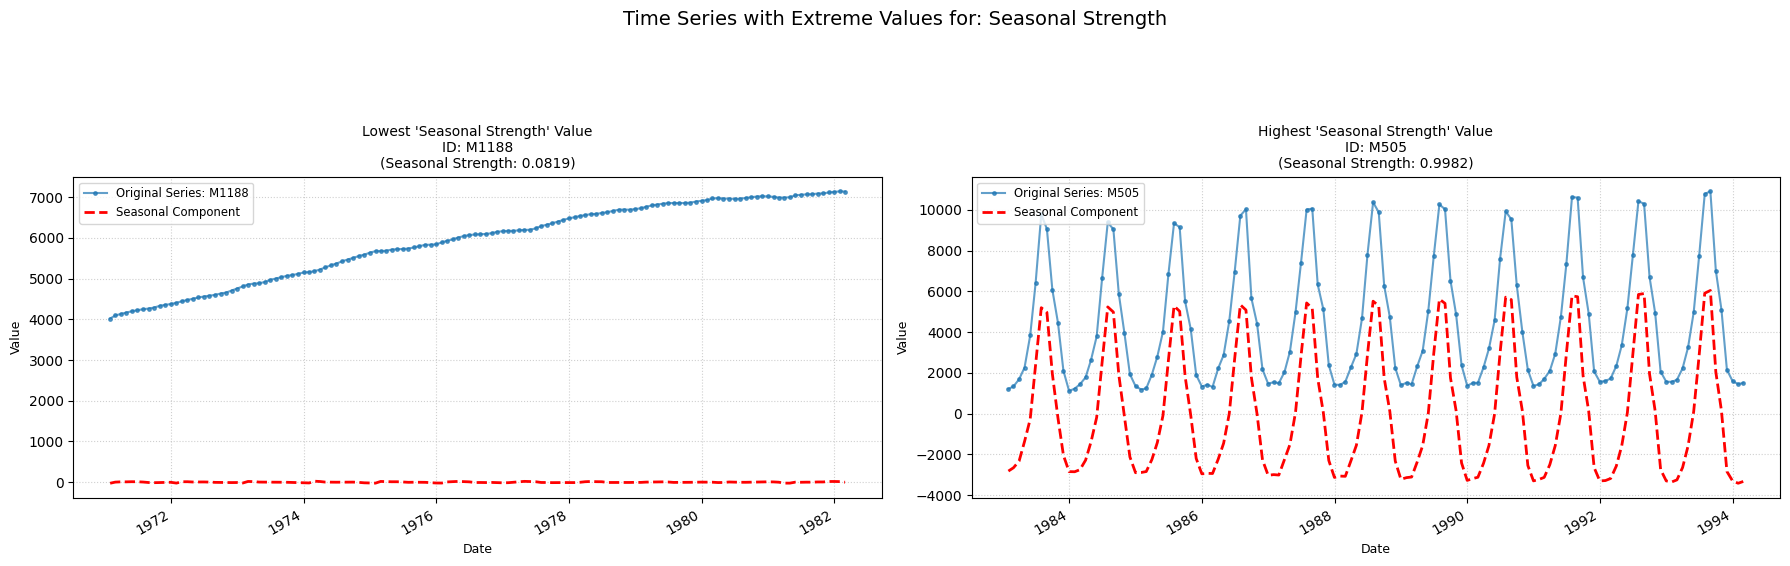

In [15]:
# --- Feature to Plot ---
feature_to_plot = "Seasonal Strength"

# --- Check if data for the feature is available ---
if feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_id"],
        f"Highest '{feature_to_plot}' Value": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_val"],
        f"Highest '{feature_to_plot}' Value": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']

            seasonal_period_for_stl = 12 
            seasonal_smoother_len = 7  
            
            if len(series_np) <= 2 * seasonal_smoother_len :
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short for STL: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short for STL', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- STL Decomposition for "Trend Strength" ---
            recalculated_feature_value = np.nan
            trend_component_to_plot = None
            
            try:
                stl = STL(series_np, period=seasonal_period_for_stl, seasonal=seasonal_smoother_len, robust=True)
                res = stl.fit()
                
                trend_component = res.trend
                seasonal_component_to_plot = res.seasonal 
                remainder_component = res.resid  

                var_R = np.var(remainder_component, ddof=1)
                var_TR = np.var(series_np - seasonal_component, ddof=1) 
                
                if var_TR <= 1e-10:
                    recalculated_feature_value = 0.0
                else:
                    recalculated_feature_value = max(0.0, 1.0 - (var_R / var_TR))
            except Exception as e:
                recalculated_feature_value = "STL Error"


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Original Series: {target_id}", alpha=0.7)

            if seasonal_component_to_plot is not None:
                ax.plot(series_dates, seasonal_component_to_plot, linestyle='--', color='red', lw=2, label="Seasonal Component")

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]

            if pd.notna(stored_feature_val):
                title_parts.append(f"(Seasonal Strength: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})")
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]):
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **Parameters Table**

In [16]:
parameter_details_list = [
    {
        "Parameter": "period", "Type": "int", 
        "Description": "Frequency of the time series (e.g. 12 for monthly)", 
        "Default": "1"
    },
    {
        "Parameter": "seasonal", "Type": "int",
        "Description": "Length of the seasonal smoother (must be odd).",
        "Default": "7"
    },
    {
        "Parameter": "robust", "Type": "bool",
        "Description": "Flag for robust fitting.",
        "Default": "False"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
period,int,1,Frequency of the time series (e.g. 12 for monthly)
seasonal,int,7,Length of the seasonal smoother (must be odd).
robust,bool,False,Flag for robust fitting.


##### **Calculation**

1.	**STL Decomposition:** The time series Yt is decomposed into trend (Tt), seasonal (St), and remainder (Rt) components, using an STL decomposition.

2.	**Detrended Series:** The detrended series is calculated as Yt′=Yt−Tt=St+Rt.

3.	**Variances Calculation:**
    - The variance of the remainder component is calculated: Var(Rt).
    - The variance of the detrended series is calculated: Var(Yt′).

4.	**Seasonal Strength Calculation:** The value for seasonal strength is computed as max (0, 1 − Var(Yt′) * Var(Rt)). This value is capped between 0 and 1 and returned.


##### **Practical Usefulness Examples**

**Retail Demand Planning:** A high seasonal strength for ice cream sales (peaking in summer) allows a company to confidently plan production and marketing efforts around these predictable peaks and troughs.

**Tourism Industry:** Hotels can use the seasonal strength of booking data to optimize pricing, staffing and promotions, anticipating high and low seasons.



## **window_fluctuation**

Measures the proportion of large changes over short time-windows.

**Low value:** Means the fluctuation of the time-series is more structured and shows few signs of randomness.  
**High value:** Means the fluctuation of the time-series shows signs of randomness.

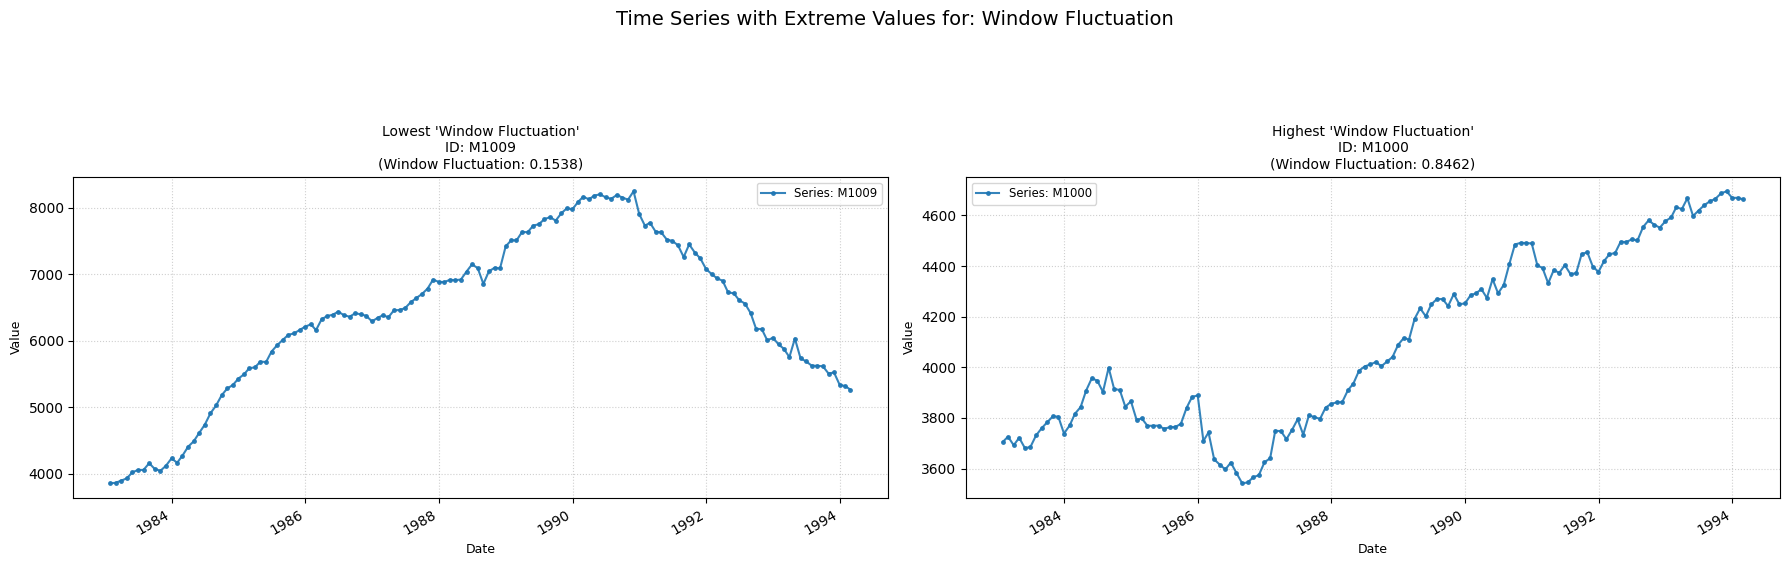

In [17]:
# --- Feature to Plot ---
feature_to_plot = "Window Fluctuation" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.	**Defining Window Sizes:** Approximately 50 window sizes are generated, logarithmically spaced from a minimum defined size up to half the series length. Duplicates are removed and if fewer than 12 unique τ values remain, the feature returns 0.

2.	**Cumulative Sum:** The series is then transformed into its cumulative sum.

3.	**Fluctuation Calculation (for each Window Size):** For each unique window size the cumulative sum series is divided into non-overlapping segments of length τ. For each segment:
    - A linear trend is fitted to the segment data points and then is subtracted to get a detrended segment.
    - For the "rsrangefit" method: The squared range of this detrended segment is calculated.
    - For the "dfa" method: The sum of squares of the values in the detrended segment is calculated.
The values for all segments are then aggregated.

4.	**Log-Log Analysis and Breakpoint Detection:** The logarithms of the window sizes and their corresponding fluctuation values are computed using an algorithm that searches for an optimal breakpoint. This is done by iterating through possible split points. For each split point i:
    - Fit a linear regression to the first i points.
    - Fit another linear regression to the remaining points.
    - Calculate the sum of squared errors (residuals) for both fits. The total sum of squared errors for this split point i is stored.
The split point i that yields the minimum total sum of squared errors is chosen as the optimal breakpoint. A minimum number of points is required for each regression.

5.	**Final Computation:** The final computed and returned value is the proportion of window sizes that fall into the first linear segment (before the optimal breakpoint).



##### **Practical Usefulness Examples**

**Financial Time Series:** Can help distinguish between periods of persistent trending (Hurst exponent > 0.5) and anti-persistent, mean-reverting behavior (Hurst < 0.5) in asset prices, informing trading strategies.

**Geophysical Data Analysis:** In analyzing earthquake data or river flow levels, this feature can characterize the long-range dependence or memory effects, helping to understand the underlying physical processes.


## **st_variation**

Computes the average of the cube of sucessive time-series differences.

**Low value:** Means the average of the short-term variation across the series is low.  
**High value:** Means the average of the short-term variation across the series is high, indicating a frantic behaviour of the data points.

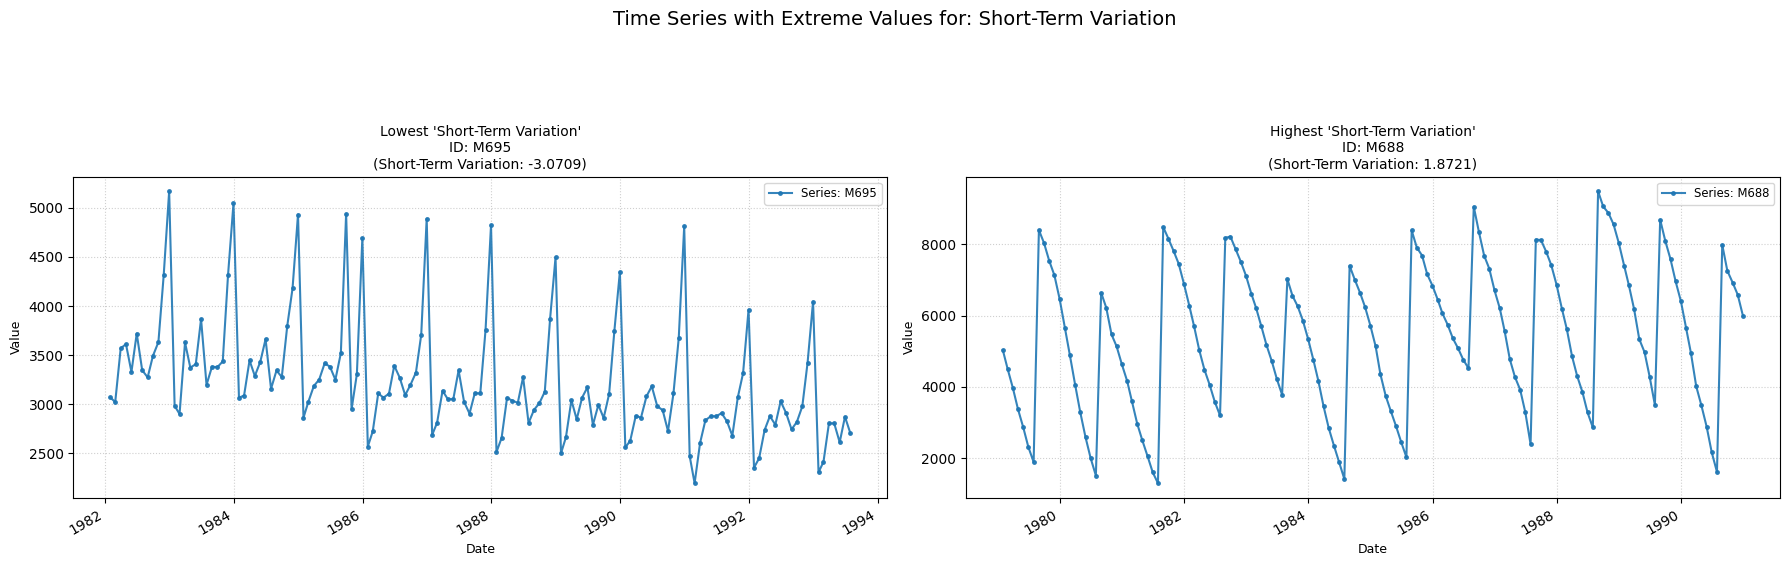

In [18]:
# --- Feature to Plot ---
feature_to_plot = "Short-Term Variation" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.	**Sucessive Differences:** Iterate through the time series from the second point to the penultimate point (t=1 to N−1), computing a comparison between each Yt point and its previous Yt-1 point.

3.	**Final Counting:** The number of times Yt > Yt−1 is then counted and returned.


##### **Practical Usefulness Examples**

**Quality Control:** In a manufacturing process, if a product dimension shows low short-term variation, it suggests stability. An increase in reversals might indicate an emerging issue.

**Algorithmic Trading:** A high number of local upward movements might suggest short-term momentum that a trading algorithm could try to exploit.

## **diff_series**

Computes the autocorrelation value of the differenced series.

**Low value:** Means there is no linear relationship between past and current values in the de-trended series.  
**High value:** Means there is a significant linear relationship between past and current values in the de-trended series.

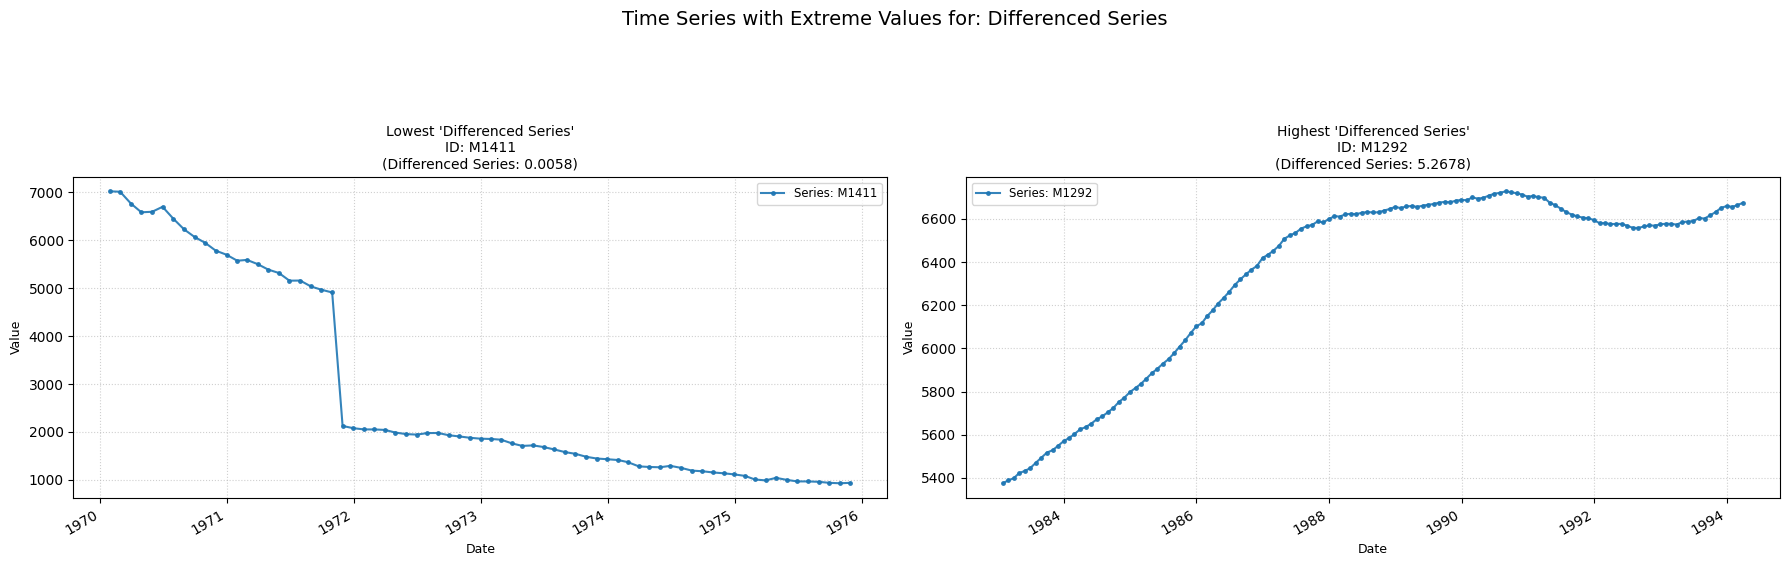

In [19]:
# --- Feature to Plot ---
feature_to_plot = "Differenced Series" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.	**First Differencing:** A new time series is created by taking the first differences of the original series, DYt = Yt+1 − Yt for t=1,...,N−1.

2.	**Autocorrelation of Differenced Series:** Then the first 10 autocorrelation coefficients (ρ1,ρ2,...,ρ10) of the differenced series are calculated, using the same method as the ac feature.

3.	**Sum of Squares:** The returned value is calculated as the sum of the squares of these first 10 autocorrelation coefficients.

##### **Practical Usefulness Examples**

**Financial Returns Analysis:** Stock prices are often non-stationary (have a trend/random walk). Analyzing the autocorrelation of their differences (returns) helps identify if there's any remaining predictability after removing the primary random walk component.

**Process Improvement:** If a process output shows a trend, differencing can make it stationary. This feature can then reveal if there are lingering systematic patterns in the rate of change that could be addressed.

## **complexity**

Computes the complexity estimate of the z-normalized time series.

**Low value:** A low/null value means the series is relatively constant over time, with no big changes.  
**High value:** A high value means the series has a high complexity, with several big changes.

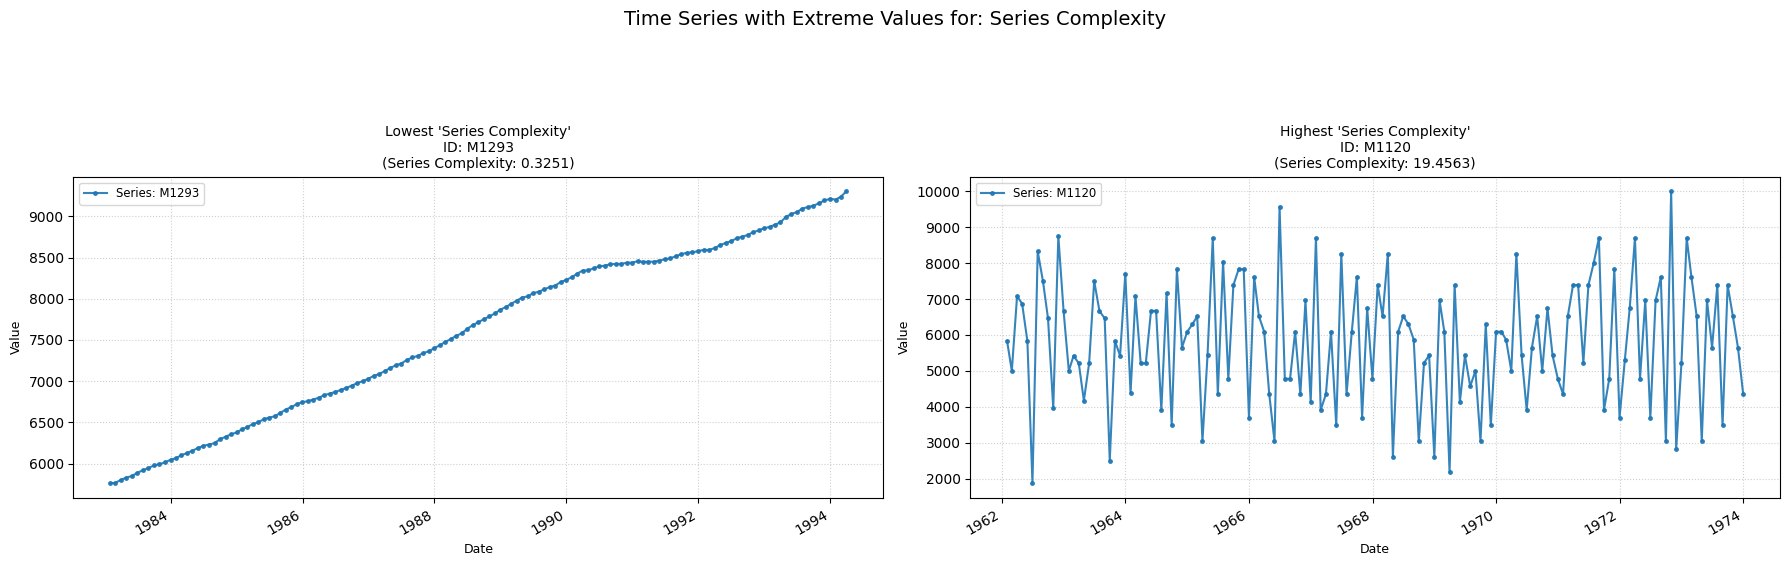

In [6]:
# --- Feature to Plot ---
feature_to_plot = "Series Complexity" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.	**Z-Normalization:** First, the series is z-normalized.

2.	**Raw Complexity Estimate:** Then, if the length of Z is less than 2, the returned value for complexity is 0. Otherwise, the complexity of the series is computed in the following fashion:
    - The first differences of the normalized series are computed.
    - The complexity estimate is computed and returned as the square root of the sum of the squares of these differences.

##### **Practical Usefulness Examples**

**Signal Processing:** When comparing different sensor readings that measure the same phenomenon, a much higher complexity in one signal might indicate noise or interference, rather than true signal variation.

**Machine Condition Monitoring:** An increase in the complexity of vibration data from a machine over time could indicate developing faults or wear and tear, as the vibrations become less regular.

## **rec_concentration**

Computes the relative position of the most probable value in relation to the mean.

**Low value:** Means the most frequent values of the series are concentrated significantly below the mean.  
**High value:** Means the most frequent values of the series are concentrated significantly above the mean.

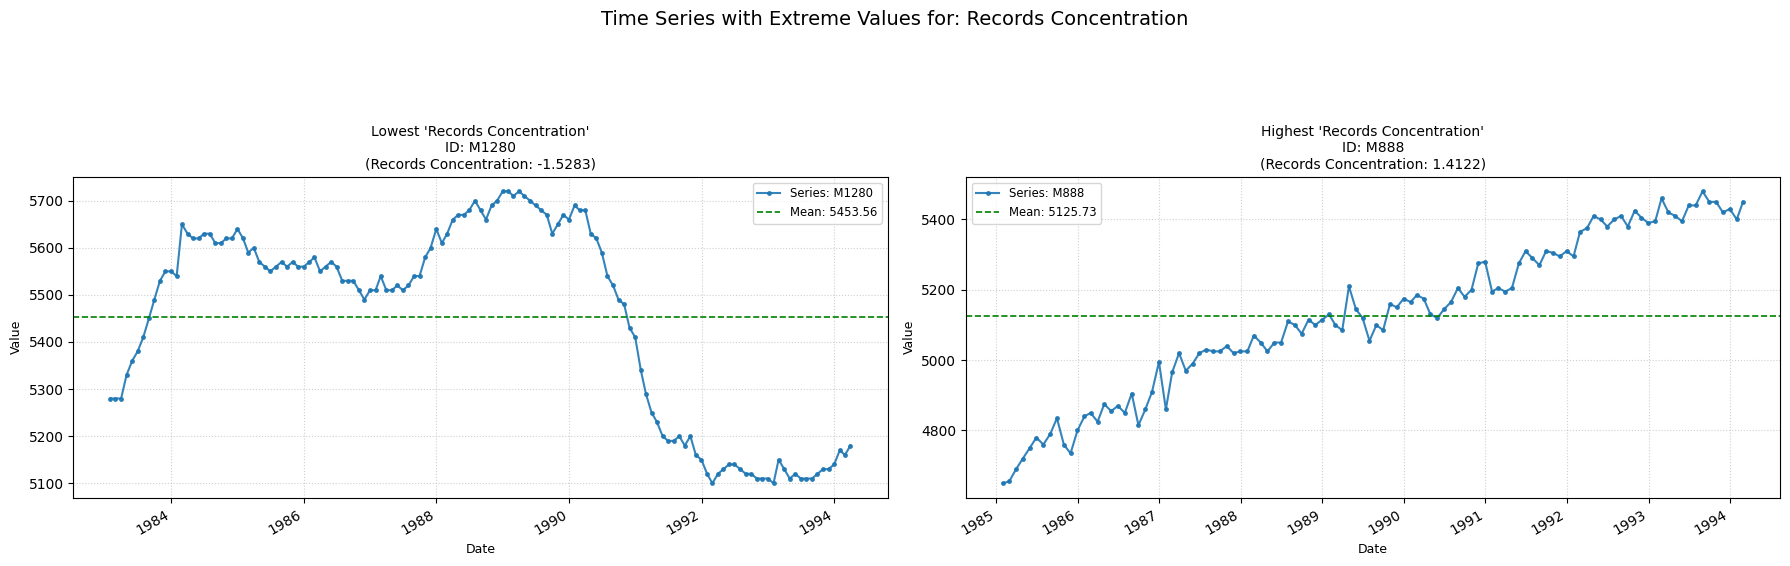

In [21]:
# --- Feature to Plot ---
feature_to_plot = "Records Concentration" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)

            if len(series_np) > 0:
                mean_val = np.mean(series_np)
                ax.axhline(mean_val, color='green', linestyle='--', linewidth=1.2, label=f'Mean: {mean_val:.2f}')
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **No Parameters**

##### **Calculation**

1.	**Data Range:** The minimum and maximum values of the time series are determined.

2.	**Binning:** The calculated range is divided into 10 equal-width bins.

3.	**Histogram:** The number of data points from the time series that fall into each of the 10 bins are counted.

4.	**Mode Identification:** The bin with the highest count (the modal bin) is identified.

5.	**Feature Value:** The returned value is the midpoint (center value) of this modal bin.

##### **Practical Usefulness Examples**

**Customer Segmentation:** While analyzing customer purchase frequency data, this feature might reveal common purchasing patterns (most customers buy 2-3 times a month, for example), helping to segment customers.

**Sensor Data Validation:** If a sensor typically outputs values concentrated in a specific range, a shift in this feature could indicate a calibration issue or a real change in the measured environment.


## **centroid**

Computes the centroid along the time axis.

**Low value:** Means the primary/patterns fluctuations of the series occur slowly.  
**High value:** Means the primary patterns/fluctuations of the series occur rapidly, with fast and short-term changes.

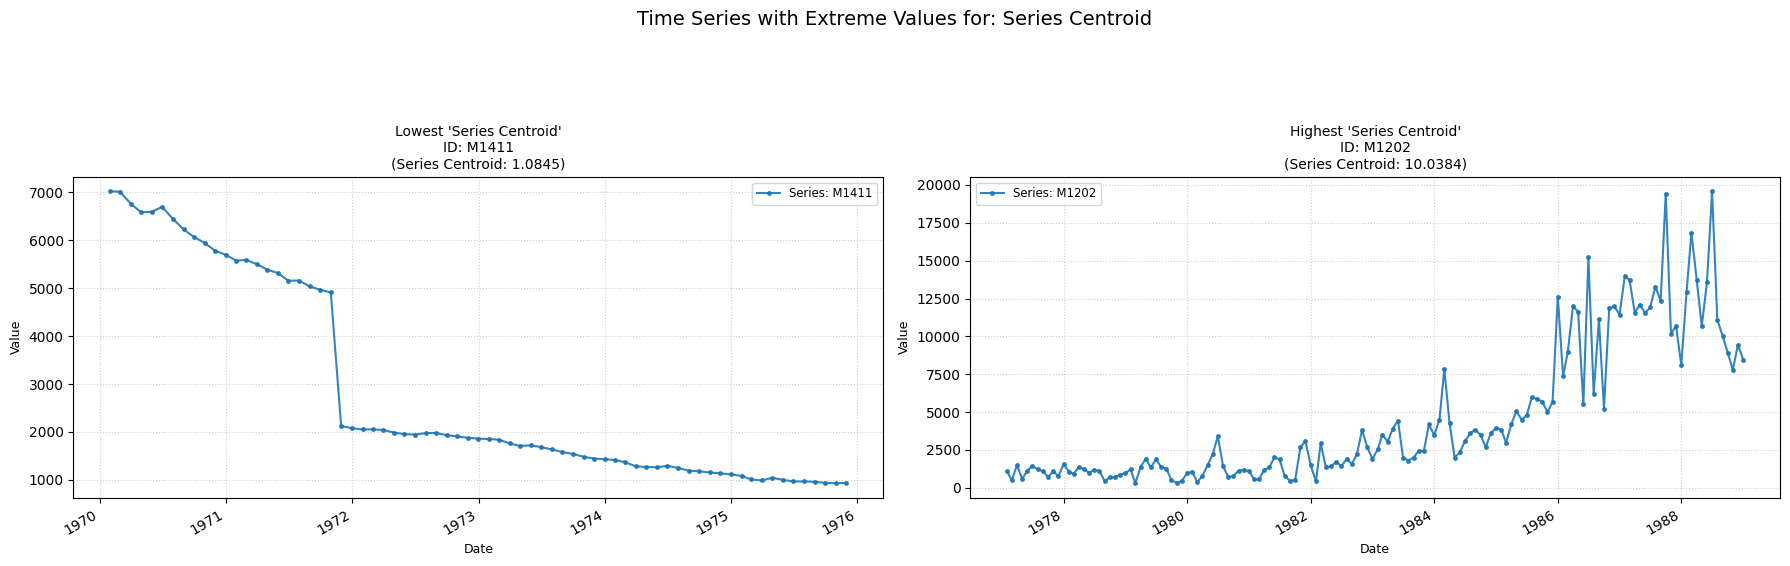

In [22]:
# --- Feature to Plot ---
feature_to_plot = "Series Centroid" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

##### **Parameters Table**

In [23]:
parameter_details_list = [
    {
        "Parameter": "fs", "Type": "int", 
        "Description": "Sampling frequency", 
        "Default": "Mandatory"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
fs,int,Mandatory,Sampling frequency


##### **Calculation**

1.	**Power Spectral Density (PSD):** The PSD of the time series is computed, which shows the power of the signal at each frequency f.
 
2.	**Centroid Calculation:** The spectral centroid C, which is returned, is computed as the power-weighted average of the frequencies. The sum is over all frequency bins k.

##### **Practical Usefulness Examples**

**Audio Analysis:** In music information retrieval, the spectral centroid distinguishes between "bright" sounds (high centroid, like cymbals) and "dull" sounds (low centroid, like a bass drum), aiding in instrument recognition or genre classification.

**Vibration Analysis:** For machine diagnostics, a shift in the spectral centroid of vibration signals can indicate changes in operational speed or the emergence of specific fault frequencies (bearing defects often have characteristic high-frequency components, for example).